In [347]:
import coinrun
import skimage
import matplotlib.pyplot as plt
import numpy as np
import scipy
import gym
import random
from coinrun import setup_utils, make
from skimage.color import rgb2gray
from skimage import morphology
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.morphology import *
from skimage import feature
from skimage.filters import *
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet
from scipy import ndimage
%matplotlib inline

In [68]:
setup_utils.setup_and_load(use_cmd_line_args=False, num_levels=2, set_seed=-1, paint_vel_info=0, is_high_res=True)
env = make('standard', 1)

# Num levels means number of distinct training levels
# Seed will change which levels are picked

{'num_levels': 2, 'set_seed': -1, 'paint_vel_info': 0, 'is_high_res': True}
{'run_id': 'tmp', 'restore_id': None, 'game_type': 'standard', 'architecture': 'impala', 'use_lstm': 0, 'num_envs': 32, 'num_levels': 0, 'set_seed': -1, 'num_steps': 256, 'num_minibatches': 8, 'ppo_epochs': 3, 'entropy_coeff': 0.01, 'learning_rate': 0.0005, 'gamma': 0.999, 'paint_vel_info': -1, 'use_batch_norm': 0, 'dropout': 0.0, 'use_data_augmentation': 0, 'l2_weight': 0.0, 'epsilon_greedy': 0.0, 'frame_stack': 1, 'use_black_white': 0, 'save_interval': 10, 'num_eval': 20, 'rep': 1, 'test': False, 'train_eval': False, 'test_eval': False, 'high_difficulty': False, 'is_high_res': False}
{'run_id': 'tmp', 'restore_id': None, 'game_type': 'standard', 'architecture': 'impala', 'use_lstm': 0, 'num_envs': 32, 'num_levels': 2, 'set_seed': -1, 'num_steps': 256, 'num_minibatches': 8, 'ppo_epochs': 3, 'entropy_coeff': 0.01, 'learning_rate': 0.0005, 'gamma': 0.999, 'paint_vel_info': 0, 'use_batch_norm': 0, 'dropout': 0.0,

In [69]:
print (env.action_space)
print (env.observation_space)

Discrete(7)
Box(64, 64, 3)


In [70]:
env.step(np.array([0]))

(array([[[[117, 178, 152],
          [117, 178, 152],
          [117, 178, 152],
          ...,
          [117, 178, 152],
          [117, 178, 152],
          [117, 178, 152]],
 
         [[117, 178, 152],
          [117, 178, 152],
          [117, 178, 152],
          ...,
          [117, 178, 152],
          [117, 178, 152],
          [117, 178, 152]],
 
         [[117, 178, 152],
          [117, 178, 152],
          [117, 178, 152],
          ...,
          [117, 178, 152],
          [117, 178, 152],
          [117, 178, 152]],
 
         ...,
 
         [[190, 224, 197],
          [190, 224, 197],
          [190, 224, 197],
          ...,
          [158, 204, 179],
          [158, 204, 179],
          [158, 204, 179]],
 
         [[190, 224, 197],
          [190, 224, 197],
          [190, 224, 197],
          ...,
          [158, 204, 179],
          [158, 204, 179],
          [158, 204, 179]],
 
         [[190, 224, 197],
          [190, 224, 197],
          [190, 224, 197],
   

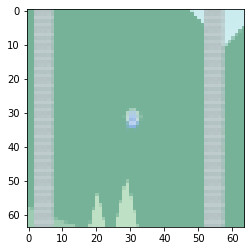

In [413]:
for action in np.random.randint(0, 7, 100):
    action = np.array([action])
    obs = env.step(action)[0][0]
plt.imshow(obs)
#     plt.show()

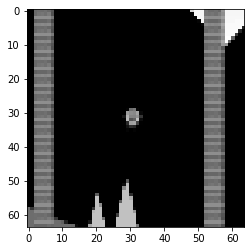

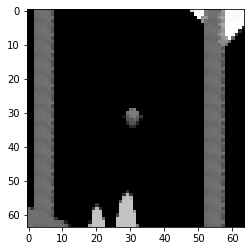

array([[0.63985451, 0.63985451, 0.75137255, ..., 0.8980051 , 0.8980051 ,
        0.8980051 ],
       [0.63985451, 0.63985451, 0.75137255, ..., 0.8980051 , 0.8980051 ,
        0.8980051 ],
       [0.63985451, 0.63985451, 0.74856706, ..., 0.89883843, 0.89883843,
        0.89883843],
       ...,
       [0.75459804, 0.75459804, 0.75459804, ..., 0.63985451, 0.63985451,
        0.63985451],
       [0.75459804, 0.75459804, 0.75459804, ..., 0.63985451, 0.63985451,
        0.63985451],
       [0.75459804, 0.75459804, 0.74661765, ..., 0.63985451, 0.63985451,
        0.63985451]])

In [414]:
def show(obs):
    plt.imshow(obs, cmap=plt.cm.gray)
    plt.show()

def denoise(obs):
    obs = rgb2gray(obs)
    show(obs)
    obs = opening(obs)
    show(obs)
    return obs

denoise(obs)

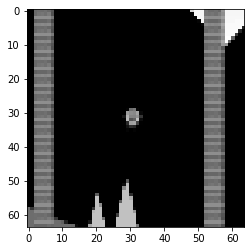

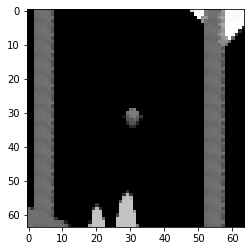

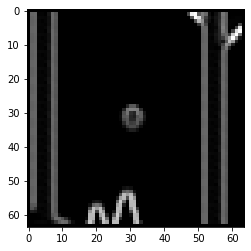

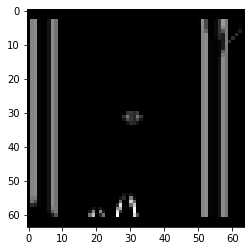

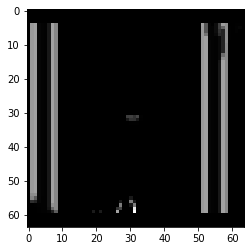

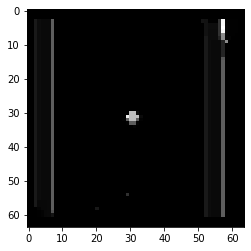

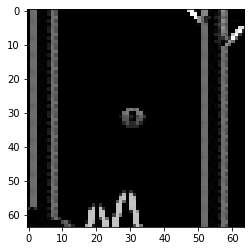

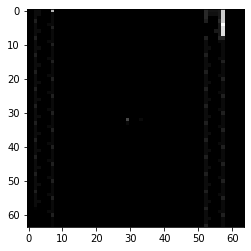

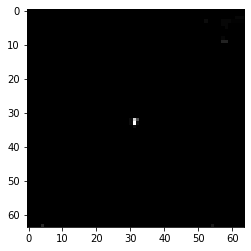

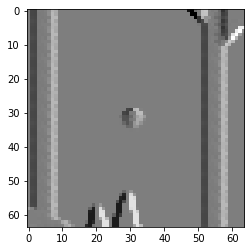

In [424]:
def edges(obs):
    obs = rgb2gray(obs)
    sobel_obs = np.abs(sobel(obs))
    show(sobel_obs)
    s1 = ndimage.filters.minimum_filter1d(sobel_obs, 5, axis=0)
    show(s1)
    s2 = ndimage.filters.minimum_filter1d(s1, 3, axis=0)
    show(s2)
    s3 = ndimage.filters.minimum_filter1d(s1, 3, axis=1)
    show(s3)
#     show(sobel_h(obs))
    f = [[-2, 0, 2]]
    show(np.abs(ndimage.convolve(obs, np.array(f))))
    im = ndimage.filters.minimum_filter1d(ndimage.filters.minimum_filter1d(np.abs(ndimage.convolve(obs, np.array(f))), 3, axis=1), 4, axis=0)
    show(im)
    f = [[-2], [0], [2]]
    im = ndimage.filters.minimum_filter1d(ndimage.filters.minimum_filter1d(np.abs(ndimage.convolve(obs, np.array(f))), 3, axis=0), 4, axis=1)
    show(im)
    show(ndimage.convolve(obs, np.array(f).T))
    
    
#     show(sobel_v(sobel(obs)))
#     show(sobel(sobel_h(obs)))
    
    
# edges(obs)
edges(denoise(obs))


[]


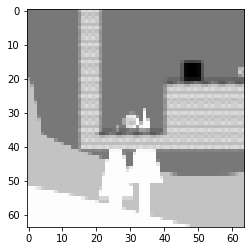

In [359]:
def blobs(obs):
    obs = rgb2gray(obs)
    plt.imshow(obs, cmap=plt.cm.gray)
    blobs = feature.blob_log(obs)
    print (blobs)
    plt.scatter(blobs[:, 1], blobs[:, 0])
    plt.show()
    
blobs(obs)

In [174]:
def agent(obs):
    # Agent is always in the center of the image
    return np.array((32, 32))

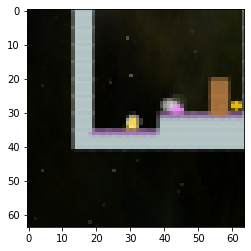

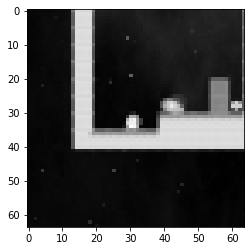

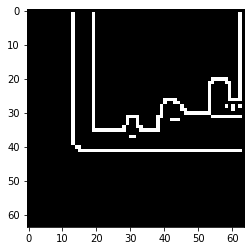

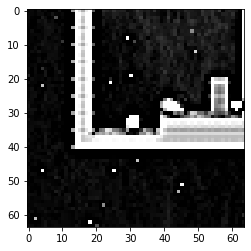

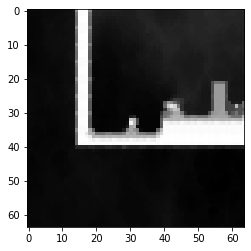

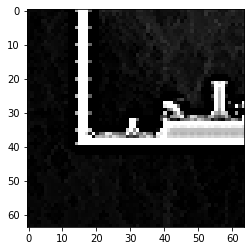

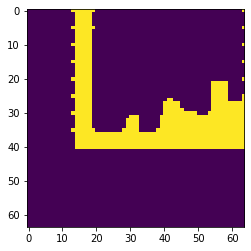

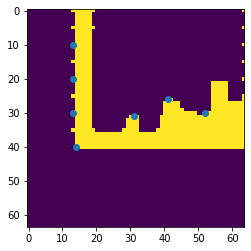

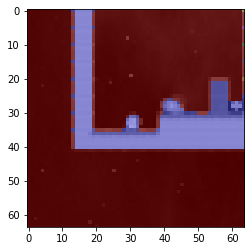

In [248]:
def segment(obs):
    plt.imshow(obs)
    plt.show()
    obs = rgb2gray(obs)
    plt.imshow(obs, cmap=plt.cm.gray)
    plt.show()
    
    edges1 = feature.canny(obs, 1)
    plt.imshow(edges1, cmap=plt.cm.gray)
    plt.show()
    
    result_1 = unsharp_mask(obs, radius=1, amount=10)
    plt.imshow(result_1, cmap=plt.cm.gray)
    plt.show()
    
    selem = disk(1)
    eroded = erosion(obs, selem)
    plt.imshow(eroded, cmap=plt.cm.gray)
    plt.show()
    
    result_1 = unsharp_mask(eroded, radius=1, amount=10)
    plt.imshow(result_1, cmap=plt.cm.gray)
    plt.show()
    
    # apply threshold
    thresh = threshold_otsu(obs)
    bw = closing(obs > thresh, square(3))
    plt.imshow(bw)
    plt.show()
    
    coords = corner_peaks(corner_harris(bw), min_distance=5)
    
    plt.imshow(bw)
    plt.scatter(coords[:, 1], coords[:, 0])
    plt.show()

    # label image regions
    label_image = label(bw)
    image_label_overlay = label2rgb(label_image, image=obs)
    plt.imshow(image_label_overlay)
    plt.show()
    
segment(obs)

In [176]:
def yellow(obs):
    yellow_mask = (obs[:, :, 0] > 150) & (obs[:, :, 1] > 150) & (obs[:, :, 2] < 50)
    locations = np.where(yellow_mask)
    print (locations)
coin(obs)

(array([34, 34]), array([30, 31]))


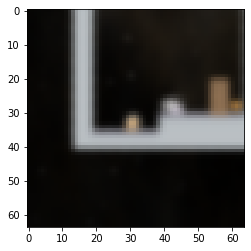

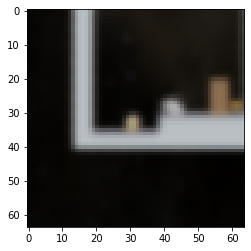

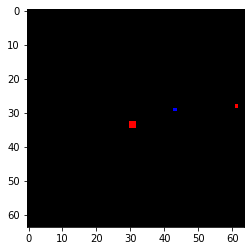

In [206]:
def background(obs):
    # Convert to float: Important for subtraction later which won't work with uint8
    image = img_as_float(obs)
    image = gaussian_filter(image, 1)

    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image

    dilated = reconstruction(seed, mask, method='dilation')
    
    plt.imshow(image)
    plt.show()
    plt.imshow(dilated)
    plt.show()
    plt.imshow((image - dilated > 0.05).astype(np.float32))
    plt.show()
background(obs)

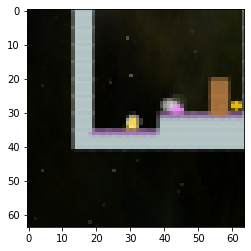

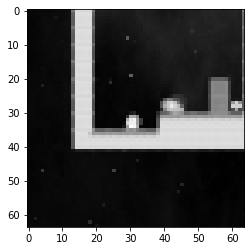

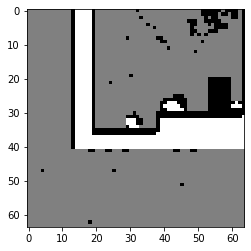

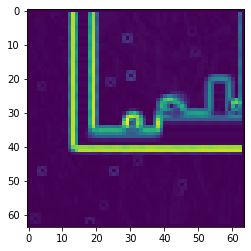

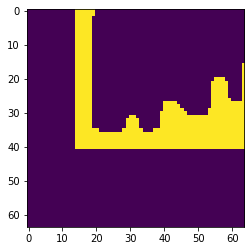

In [207]:
def segment(obs):
    plt.imshow(obs)
    plt.show()
    
    gray = rgb2gray(obs)
    plt.imshow(gray, cmap=plt.cm.gray)
    plt.show()
        
    markers = np.zeros_like(gray)
    markers[gray < 30/255.] = 1
    markers[gray > 150/255.] = 2
    plt.imshow(markers, cmap=plt.cm.gray)
    plt.show()
    
    elevation_map = sobel(gray)
    plt.imshow(elevation_map)
    plt.show()
    
    segmentation = morphology.watershed(elevation_map, markers)
    plt.imshow(segmentation)
    plt.show()

segment(obs)